In [30]:
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 69.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##Dataframe visualization

In [31]:
import pandas as pd
df = pd.read_csv('Balanced_AHR.csv', usecols=['title', 'rating', 'review_text'])
print(df.head(10))
print(df.shape)

                                      title  rating  \
0                       IMPOSIBLE DESCANSAR       2   
1              No es oro todo lo que reluce       3   
2            Un buen hotel con mucho ruido.       3   
3      SIN CALEFACCIÓN OPERATIVA Y CON FRÍO       2   
4                 Deja bastante que desear.       2   
5                    Desastre de ascensores       2   
6                             Mal mal y mal       2   
7                      Suciedad intolerable       1   
8                                Lamentable       1   
9  Sigo aquí pero quiero cambiarme de hotel       2   

                                         review_text  
0  El fin de semana mi pareja y yo hicimos una re...  
1  El hotel en general está bien, las habtiacione...  
2  El hotel es moderno, amplio y limpio, pero no ...  
3  Calefacción averiada o no operativa. Se coment...  
4  Este hotel ha bajado notoriamente su categoria...  
5  Son pequeños, se bloquean y son insuficientes ...  
6  Mal ma

#Class repartition

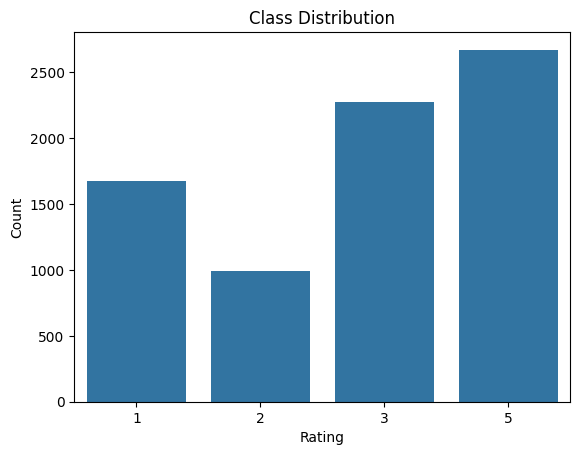

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='rating', data=df)
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Since rating 4 doesn't exist and ratings 3 and 5 are unbalanced compared to 1 and 2, we will merge ratings 1 and 2 into 1, as they both represent bad ratings.

In [33]:
df['rating'] = df['rating'].replace({2: 1})


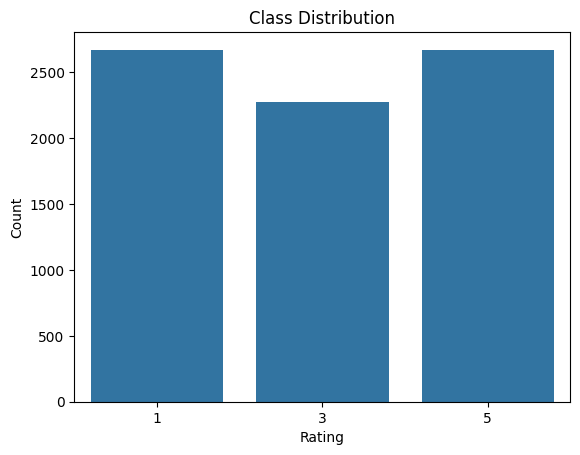

In [34]:
sns.countplot(x='rating', data=df)
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


#Text Preprocessing


##Deletion of special characters and punctuation signs

In [37]:
import re

# Cleaning function
def clean_text(text):
    text = text.lower()
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

df['cleaned_review_text'] = df["review_text"].apply(clean_text)

print(df.head(10))

                                      title  rating  \
0                       IMPOSIBLE DESCANSAR       1   
1              No es oro todo lo que reluce       3   
2            Un buen hotel con mucho ruido.       3   
3      SIN CALEFACCIÓN OPERATIVA Y CON FRÍO       1   
4                 Deja bastante que desear.       1   
5                    Desastre de ascensores       1   
6                             Mal mal y mal       1   
7                      Suciedad intolerable       1   
8                                Lamentable       1   
9  Sigo aquí pero quiero cambiarme de hotel       1   

                                         review_text  \
0  El fin de semana mi pareja y yo hicimos una re...   
1  El hotel en general está bien, las habtiacione...   
2  El hotel es moderno, amplio y limpio, pero no ...   
3  Calefacción averiada o no operativa. Se coment...   
4  Este hotel ha bajado notoriamente su categoria...   
5  Son pequeños, se bloquean y son insuficientes ...   
6 

##Deletion of foreign language words in the cvs and stopwords

In [38]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
import string


nltk.download('punkt')
DetectorFactory.seed = 0
tokenizer = ToktokTokenizer()
spanish_stopwords = set(stopwords.words('spanish'))
punctuation = set(string.punctuation)
def detect_and_tokenize(text):
    try:
        lang = detect(text)
        if lang == 'es':
            tokens = tokenizer.tokenize(text)
            filtered_tokens = [
                token.lower()
                for token in tokens
                if token.lower() not in spanish_stopwords
                and token not in punctuation
            ]
            return filtered_tokens
        else:
            return ''  # Returns empty if not in spanish
    except:
        return ''

df['cleaned_review_text'] = df['review_text'].apply(detect_and_tokenize)

# Elimination of empty rows
df = df[df['cleaned_review_text'] != '']

print(df.shape)
print(df.head(20))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(7520, 4)
                                                title  rating  \
0                                 IMPOSIBLE DESCANSAR       1   
1                        No es oro todo lo que reluce       3   
2                      Un buen hotel con mucho ruido.       3   
3                SIN CALEFACCIÓN OPERATIVA Y CON FRÍO       1   
4                           Deja bastante que desear.       1   
5                              Desastre de ascensores       1   
6                                       Mal mal y mal       1   
7                                Suciedad intolerable       1   
8                                          Lamentable       1   
9            Sigo aquí pero quiero cambiarme de hotel       1   
10                            Precio desproporcionado       3   
11  SEVILLA CENTER, UN DISGUSTO EN EL CENTRO DE SE...       1   
12                            No comáis en la piscina       3   
13                                           Estancia       3   
14             

##Lematization

In [39]:
import spacy
nlp = spacy.load('es_core_news_sm')

reviews = df["cleaned_review_text"]

df['cleaned_review_text'] = df['cleaned_review_text'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])

print(df.head(20))

                                                title  rating  \
0                                 IMPOSIBLE DESCANSAR       1   
1                        No es oro todo lo que reluce       3   
2                      Un buen hotel con mucho ruido.       3   
3                SIN CALEFACCIÓN OPERATIVA Y CON FRÍO       1   
4                           Deja bastante que desear.       1   
5                              Desastre de ascensores       1   
6                                       Mal mal y mal       1   
7                                Suciedad intolerable       1   
8                                          Lamentable       1   
9            Sigo aquí pero quiero cambiarme de hotel       1   
10                            Precio desproporcionado       3   
11  SEVILLA CENTER, UN DISGUSTO EN EL CENTRO DE SE...       1   
12                            No comáis en la piscina       3   
13                                           Estancia       3   
14                       

#Grid Search for SVM


In [40]:
df['cleaned_review_text'] = df['cleaned_review_text'].apply(lambda x: ' '.join(x))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mejores parámetros: {'svm__C': 1, 'svm__kernel': 'linear', 'tfidf__max_df': 0.7, 'tfidf__min_df': 1}
Accuracy: 0.86


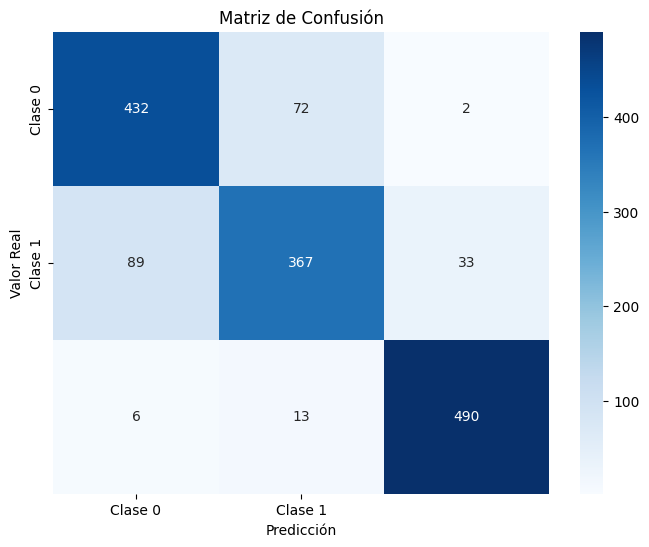

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words_es = stopwords.words('spanish')
# Get labels
y = df['rating']

# training split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review_text'], y, test_size=0.2, random_state=42)

#Pipeline of tfif and svm
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42))
])


param_grid = {
    'tfidf__min_df': [1, 5],
    'tfidf__max_df': [0.7, 0.8, 1.0],


    'svm__C': [1, 10],
    'svm__kernel': ['linear'],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


# Get best params
print(f"Mejores parámetros: {grid.best_params_}")

# Make predictions with the best paramm
y_pred = grid.best_estimator_.predict(X_test)

# Final accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)

# Plooting matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()


#Naive Bayes grid search

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.7, 'tfidf__min_df': 1}
Accuracy: 0.86


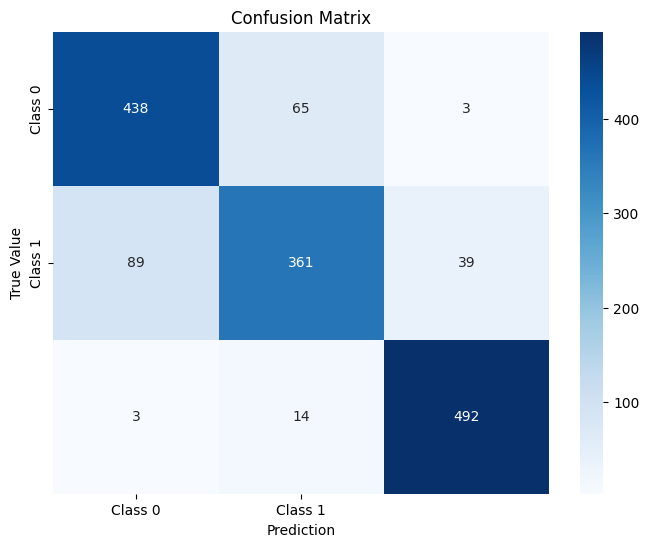

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk


# Get labels
y = df['rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review_text'], y, test_size=0.2, random_state=42)

# Pipeline with Tfidf and Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Parameter grid for GridSearchCV
param_grid = {
    'tfidf__min_df': [1, 5, 10],
    'tfidf__max_df': [0.7, 0.8, 1.0],
    'nb__alpha': [1.0, 0.1],
}

# GridSearchCV to find the best parameters
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid.best_params_}")

# Make predictions with the best model
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()


##K-NN grid search


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'distance', 'tfidf__max_df': 0.7, 'tfidf__min_df': 5}
Accuracy: 0.79


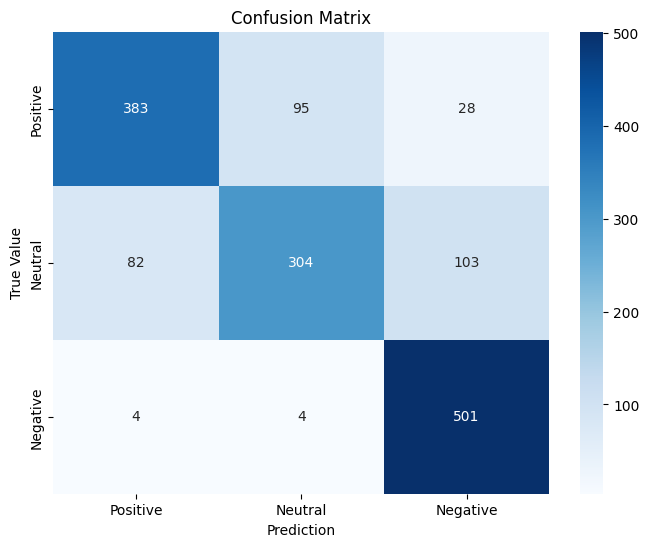

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier  # Import KNN
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Get labels
y = df['rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review_text'], y, test_size=0.2, random_state=42)

# Pipeline with Tfidf and KNN
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Parameter grid f
param_grid = {
    'tfidf__min_df': [1, 5],
    'tfidf__max_df': [0.7, 0.8, 1.0],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
}

# GridSearchCV to find the best parameters
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid.best_params_}")

# Make predictions with the best model
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()
